# Linear Regression - Top model according to the SCPM of -6.59

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/partner_i-Oficial/cement-shipping.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.drop(
    [  # Removing One-Hot encoding variables
        "Cement_Type",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

# 1. Linear Regression

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [8]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

In [9]:
n_splits = 5
repeats = 3
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.840 (0.072)
MAE: -0.654 (0.056)
MAPE: -0.015 (0.001)
R2: 0.971 (0.004)


******
[TEST]
******
RMSE: -1.081 (0.031)
MAE: -0.847 (0.036)
MAPE: -0.020 (0.001)
R2: 0.954 (0.004)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [10]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [11]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-02,37.400002,37.461648,TRAIN
1,2020-01-03,36.099998,36.932212,TRAIN
2,2020-01-03,43.900002,44.411629,TRAIN
3,2020-01-03,48.500000,47.365606,TRAIN
4,2020-01-06,46.500000,46.291141,TRAIN
...,...,...,...,...
1221,2022-04-27,47.000000,48.247547,TEST
1222,2022-04-28,47.500000,48.118018,TEST
1223,2022-04-29,37.000000,37.794639,TEST
1224,2022-05-02,47.000000,48.008756,TEST


<IPython.core.display.Javascript object>

In [12]:
df_copy_copy = df_copy.copy()
df_copy_copy["Date"] = pd.to_datetime(df_copy_copy["Date"])
df_copy_copy["Date"] = df_copy_copy["Date"].dt.tz_localize(None)

df_pred_copy = df_pred.copy()
df_pred_copy["DATE"] = pd.to_datetime(df_pred_copy["DATE"])
df_pred_copy["DATE"] = df_pred_copy["DATE"].dt.tz_localize(None)

df_copy_merge = df_copy_copy.reset_index(drop=True).merge(
    df_pred_copy.reset_index(drop=True), left_index=True, right_index=True, how="inner"
)
df_copy_merge["COMPANY"] = "Partner i"
df_copy_merge["PLANT"] = "Partner i"

for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel(
    "local_model_linear_regression_tsscv_partner_i.xlsx", index=False
)
df_copy_merge.to_csv("local_model_linear_regression_tsscv_partner_i.csv", index=False)

<IPython.core.display.Javascript object>

In [13]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2020-01-02,37.400002,37.461648,TRAIN,1
1,2020-01-03,36.099998,36.932212,TRAIN,1
2,2020-01-03,43.900002,44.411629,TRAIN,1
3,2020-01-03,48.500000,47.365606,TRAIN,1
4,2020-01-06,46.500000,46.291141,TRAIN,1
...,...,...,...,...,...
1221,2022-04-27,47.000000,48.247547,TEST,5
1222,2022-04-28,47.500000,48.118018,TEST,5
1223,2022-04-29,37.000000,37.794639,TEST,5
1224,2022-05-02,47.000000,48.008756,TEST,5


<IPython.core.display.Javascript object>

In [14]:
(df_pred["SET"] == "TEST").sum()

1020

<IPython.core.display.Javascript object>

In [15]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [16]:
df[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,1226.0,43.514405,5.047022,32.400002,37.425001,46.299999,47.299999,51.400002


<IPython.core.display.Javascript object>

In [17]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

Fold: 1
******
[TRAIN]
******
RMSE: 1.077 (0.000)
MAE: 0.827 (0.000)
MAPE: 0.019 (0.000)
R2: 0.953 (0.000)


******
[TEST]
******
RMSE: 1.077 (0.000)
MAE: 0.827 (0.000)
MAPE: 0.019 (0.000)
R2: 0.953 (0.000)




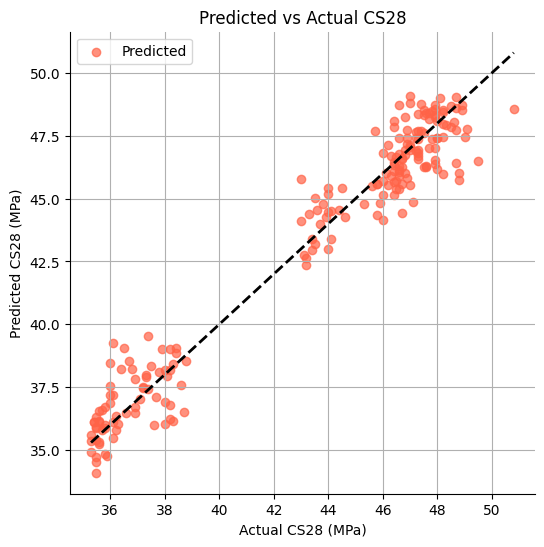

Fold: 2
******
[TRAIN]
******
RMSE: 1.047 (0.000)
MAE: 0.797 (0.000)
MAPE: 0.018 (0.000)
R2: 0.955 (0.000)


******
[TEST]
******
RMSE: 1.047 (0.000)
MAE: 0.797 (0.000)
MAPE: 0.018 (0.000)
R2: 0.955 (0.000)




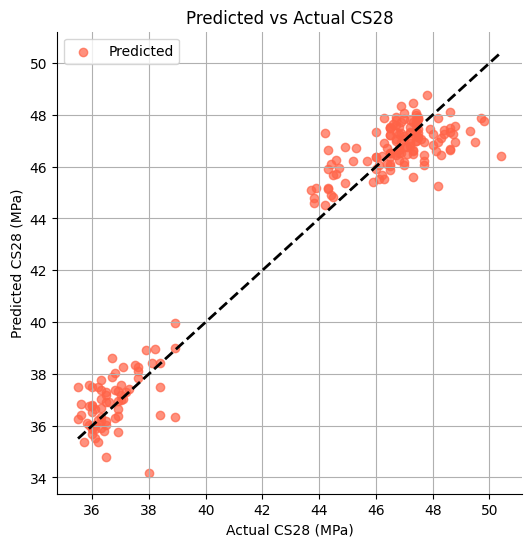

Fold: 3
******
[TRAIN]
******
RMSE: 1.138 (0.000)
MAE: 0.906 (0.000)
MAPE: 0.021 (0.000)
R2: 0.951 (0.000)


******
[TEST]
******
RMSE: 1.138 (0.000)
MAE: 0.906 (0.000)
MAPE: 0.021 (0.000)
R2: 0.951 (0.000)




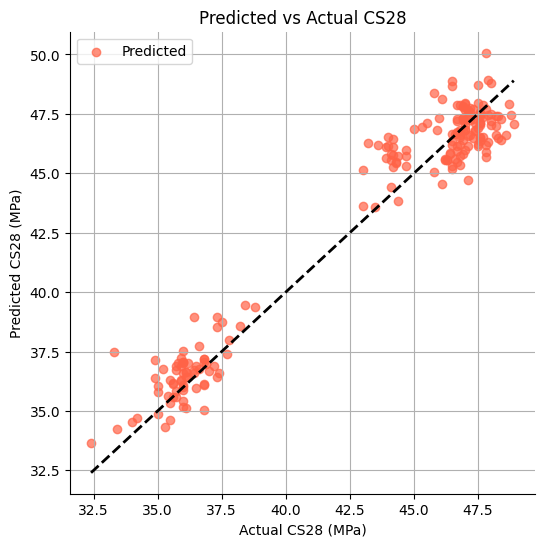

Fold: 4
******
[TRAIN]
******
RMSE: 1.066 (0.000)
MAE: 0.856 (0.000)
MAPE: 0.020 (0.000)
R2: 0.961 (0.000)


******
[TEST]
******
RMSE: 1.066 (0.000)
MAE: 0.856 (0.000)
MAPE: 0.020 (0.000)
R2: 0.961 (0.000)




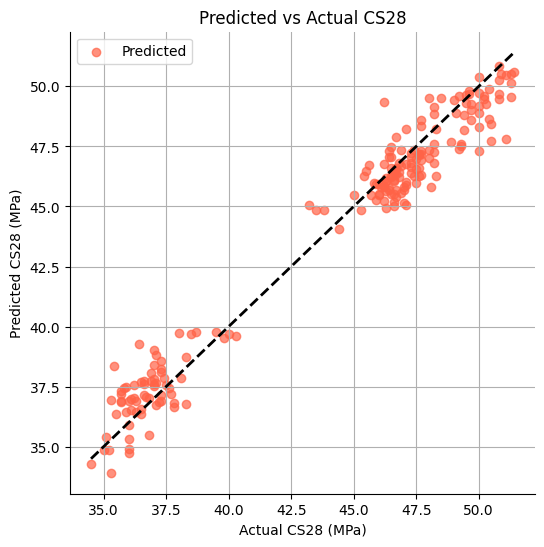

Fold: 5
******
[TRAIN]
******
RMSE: 1.078 (0.000)
MAE: 0.850 (0.000)
MAPE: 0.020 (0.000)
R2: 0.951 (0.000)


******
[TEST]
******
RMSE: 1.078 (0.000)
MAE: 0.850 (0.000)
MAPE: 0.020 (0.000)
R2: 0.951 (0.000)




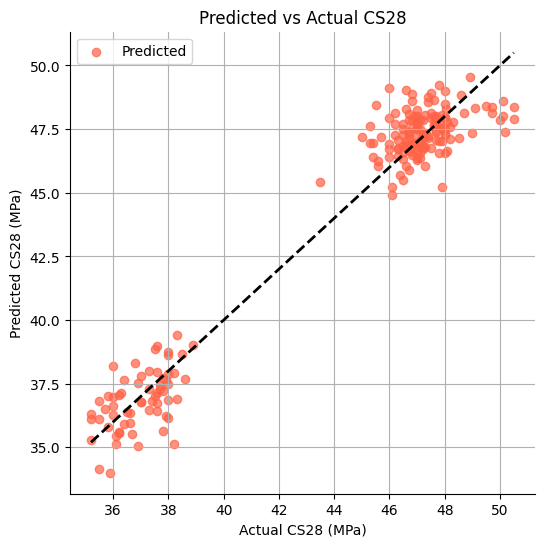

<IPython.core.display.Javascript object>

In [18]:
test_data = df_pred[df_pred["SET"] == "TEST"]

for fold in test_data["FOLD"].unique():
    test_data_f = test_data[test_data["FOLD"].eq(fold)]
    print("Fold:", fold)
    real = test_data_f["CS28"]
    pred = test_data_f["CS28_PRED"]
    results = score_regression_metrics(real, pred, real, pred)
    print_scores(results, METRICS, METRICS_DICT)
    plt.figure(figsize=(6, 6))
    plt.scatter(
        real,
        pred,
        color="tomato",
        alpha=0.7,
        label="Predicted",
    )
    plt.plot(
        [real.min(), real.max()],
        [real.min(), real.max()],
        color="black",
        linestyle="--",
        linewidth=2,
    )
    plt.xlabel("Actual CS28 (MPa)")
    plt.ylabel("Predicted CS28 (MPa)")
    plt.title("Predicted vs Actual CS28")
    plt.legend()
    plt.grid(True)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()

Fold: 1
******
[TRAIN]
******
RMSE: 1.077 (0.000)
MAE: 0.827 (0.000)
MAPE: 0.019 (0.000)
R2: 0.953 (0.000)


******
[TEST]
******
RMSE: 1.077 (0.000)
MAE: 0.827 (0.000)
MAPE: 0.019 (0.000)
R2: 0.953 (0.000)


Fold: 2
******
[TRAIN]
******
RMSE: 1.047 (0.000)
MAE: 0.797 (0.000)
MAPE: 0.018 (0.000)
R2: 0.955 (0.000)


******
[TEST]
******
RMSE: 1.047 (0.000)
MAE: 0.797 (0.000)
MAPE: 0.018 (0.000)
R2: 0.955 (0.000)


Fold: 3
******
[TRAIN]
******
RMSE: 1.138 (0.000)
MAE: 0.906 (0.000)
MAPE: 0.021 (0.000)
R2: 0.951 (0.000)


******
[TEST]
******
RMSE: 1.138 (0.000)
MAE: 0.906 (0.000)
MAPE: 0.021 (0.000)
R2: 0.951 (0.000)


Fold: 4
******
[TRAIN]
******
RMSE: 1.066 (0.000)
MAE: 0.856 (0.000)
MAPE: 0.020 (0.000)
R2: 0.961 (0.000)


******
[TEST]
******
RMSE: 1.066 (0.000)
MAE: 0.856 (0.000)
MAPE: 0.020 (0.000)
R2: 0.961 (0.000)


Fold: 5
******
[TRAIN]
******
RMSE: 1.078 (0.000)
MAE: 0.850 (0.000)
MAPE: 0.020 (0.000)
R2: 0.951 (0.000)


******
[TEST]
******
RMSE: 1.078 (0.000)
MAE: 0.850 (0.

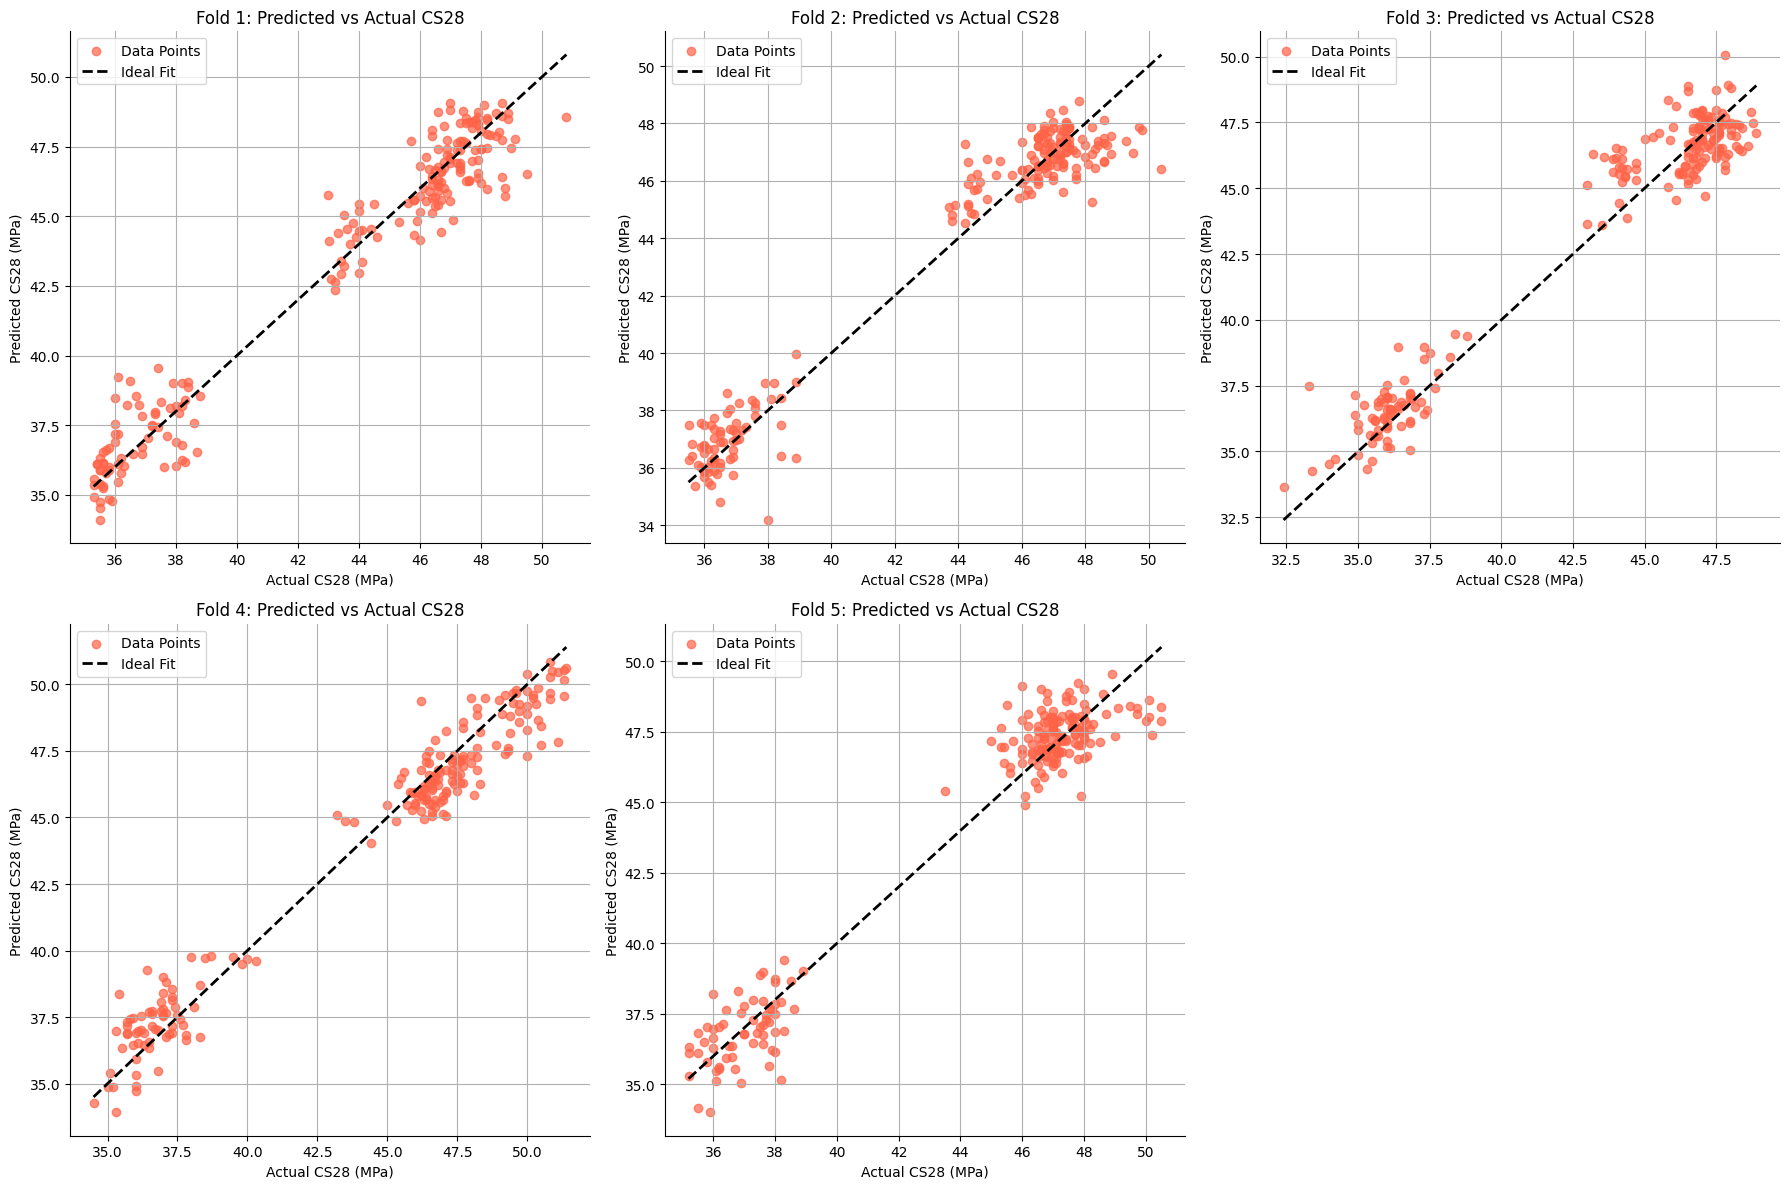

<IPython.core.display.Javascript object>

In [19]:
import matplotlib.pyplot as plt

# Assuming df_pred is already defined and contains your data
test_data = df_pred[df_pred["SET"] == "TEST"]
folds = sorted(test_data["FOLD"].unique())

# Create a figure with subplots: 2 rows x 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, fold in enumerate(folds):
    test_data_f = test_data[test_data["FOLD"] == fold]
    print("Fold:", fold)
    real = test_data_f["CS28"]
    pred = test_data_f["CS28_PRED"]
    results = score_regression_metrics(real, pred, real, pred)
    print_scores(results, METRICS, METRICS_DICT)
    
    ax = axes[i]
    ax.scatter(
        real,
        pred,
        color="tomato",
        alpha=0.7,
        label="Data Points",
    )
    ax.plot(
        [real.min(), real.max()],
        [real.min(), real.max()],
        color="black",
        linestyle="--",
        linewidth=2,
        label="Ideal Fit",
    )
    ax.set_xlabel("Actual CS28 (MPa)")
    ax.set_ylabel("Predicted CS28 (MPa)")
    ax.set_title(f"Fold {fold}: Predicted vs Actual CS28")
    ax.legend()
    ax.grid(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Remove any unused subplots if the number of folds is less than the number of subplots
for j in range(len(folds), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Fold: 1
******
[TRAIN]
******
RMSE: 1.077 (0.000)
MAE: 0.827 (0.000)
MAPE: 0.019 (0.000)
R2: 0.953 (0.000)


******
[TEST]
******
RMSE: 1.077 (0.000)
MAE: 0.827 (0.000)
MAPE: 0.019 (0.000)
R2: 0.953 (0.000)


Fold: 2
******
[TRAIN]
******
RMSE: 1.047 (0.000)
MAE: 0.797 (0.000)
MAPE: 0.018 (0.000)
R2: 0.955 (0.000)


******
[TEST]
******
RMSE: 1.047 (0.000)
MAE: 0.797 (0.000)
MAPE: 0.018 (0.000)
R2: 0.955 (0.000)


Fold: 3
******
[TRAIN]
******
RMSE: 1.138 (0.000)
MAE: 0.906 (0.000)
MAPE: 0.021 (0.000)
R2: 0.951 (0.000)


******
[TEST]
******
RMSE: 1.138 (0.000)
MAE: 0.906 (0.000)
MAPE: 0.021 (0.000)
R2: 0.951 (0.000)


Fold: 4
******
[TRAIN]
******
RMSE: 1.066 (0.000)
MAE: 0.856 (0.000)
MAPE: 0.020 (0.000)
R2: 0.961 (0.000)


******
[TEST]
******
RMSE: 1.066 (0.000)
MAE: 0.856 (0.000)
MAPE: 0.020 (0.000)
R2: 0.961 (0.000)


Fold: 5
******
[TRAIN]
******
RMSE: 1.078 (0.000)
MAE: 0.850 (0.000)
MAPE: 0.020 (0.000)
R2: 0.951 (0.000)


******
[TEST]
******
RMSE: 1.078 (0.000)
MAE: 0.850 (0.

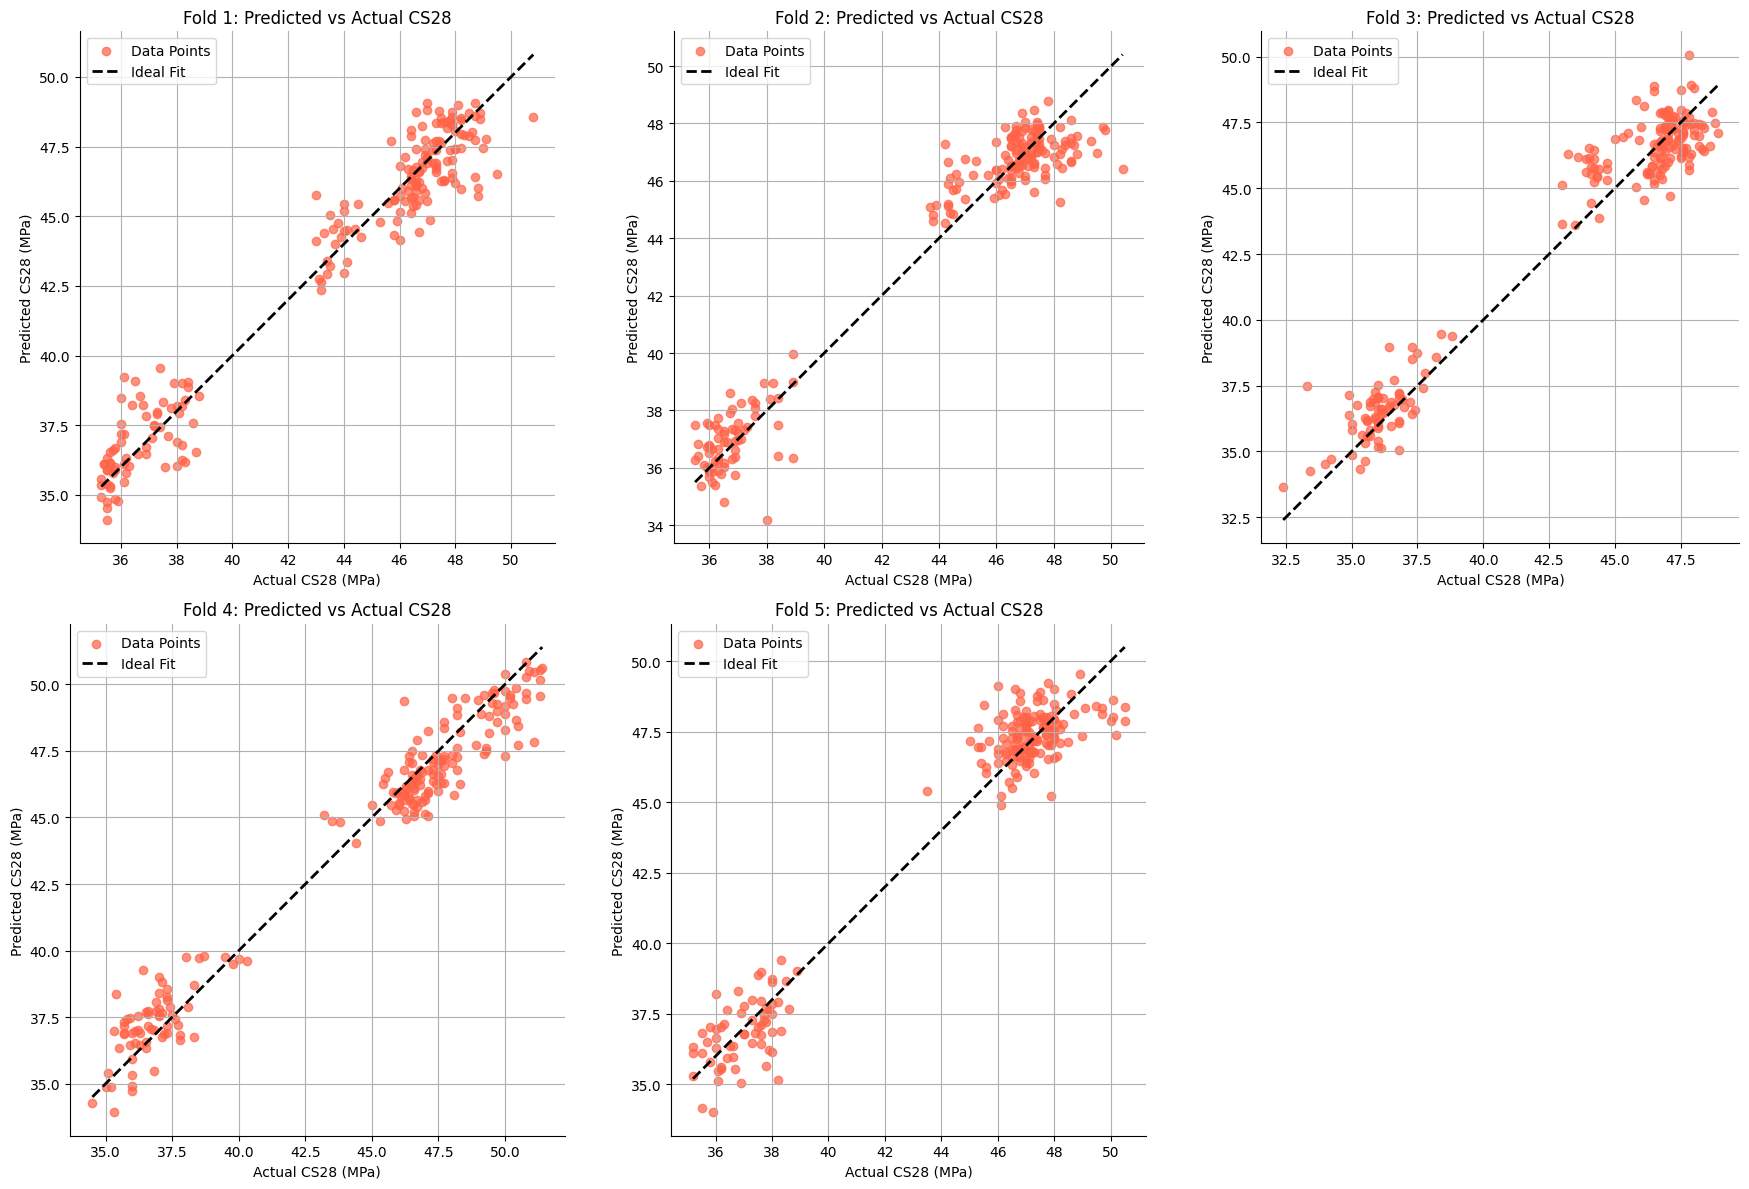

<IPython.core.display.Javascript object>

In [20]:
import matplotlib.pyplot as plt

# Assuming df_pred is already defined and contains your data
test_data = df_pred[df_pred["SET"] == "TEST"]
folds = sorted(test_data["FOLD"].unique())

# Number of folds
num_folds = len(folds)

# Determine the number of rows and columns for subplots
# For 5 folds, we'll use a 2x3 grid (will have one empty subplot)
cols = 3
rows = 2

# Create a figure with subplots: adjust figsize to ensure square subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 6, rows * 6))
axes = axes.flatten()

for i, fold in enumerate(folds):
    test_data_f = test_data[test_data["FOLD"] == fold]
    print("Fold:", fold)
    real = test_data_f["CS28"]
    pred = test_data_f["CS28_PRED"]
    results = score_regression_metrics(real, pred, real, pred)
    print_scores(results, METRICS, METRICS_DICT)
    
    ax = axes[i]
    ax.scatter(
        real,
        pred,
        color="tomato",
        alpha=0.7,
        label="Data Points",
    )
    ax.plot(
        [real.min(), real.max()],
        [real.min(), real.max()],
        color="black",
        linestyle="--",
        linewidth=2,
        label="Ideal Fit",
    )
    ax.set_xlabel("Actual CS28 (MPa)")
    ax.set_ylabel("Predicted CS28 (MPa)")
    ax.set_title(f"Fold {fold}: Predicted vs Actual CS28")
    ax.legend()
    ax.grid(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_aspect('equal', adjustable='box')  # Ensure the subplot is square

# Remove any unused subplots if the number of folds is less than the number of subplots
for j in range(num_folds, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


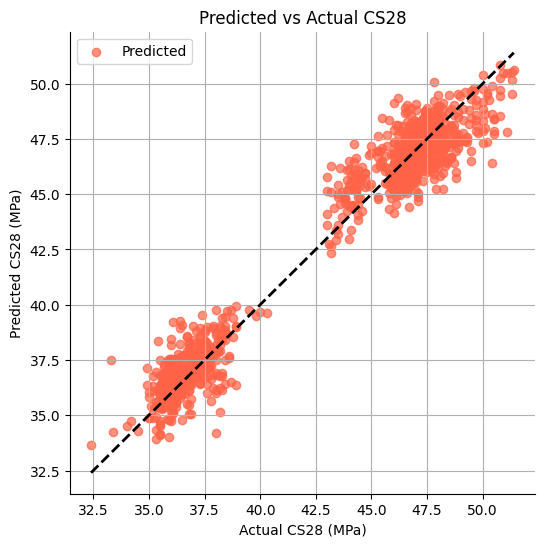

<IPython.core.display.Javascript object>

In [21]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

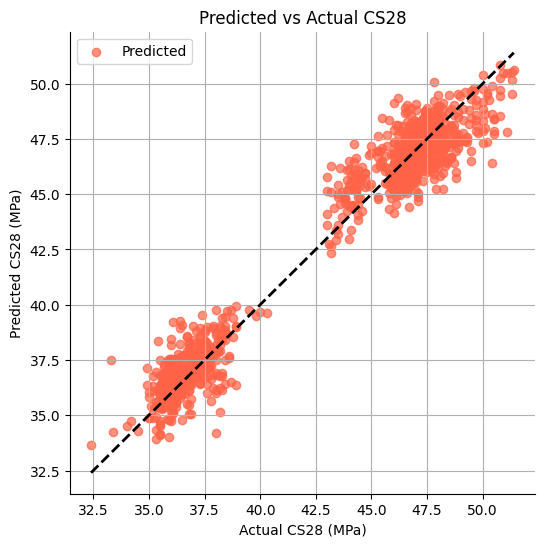

<IPython.core.display.Javascript object>

In [22]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

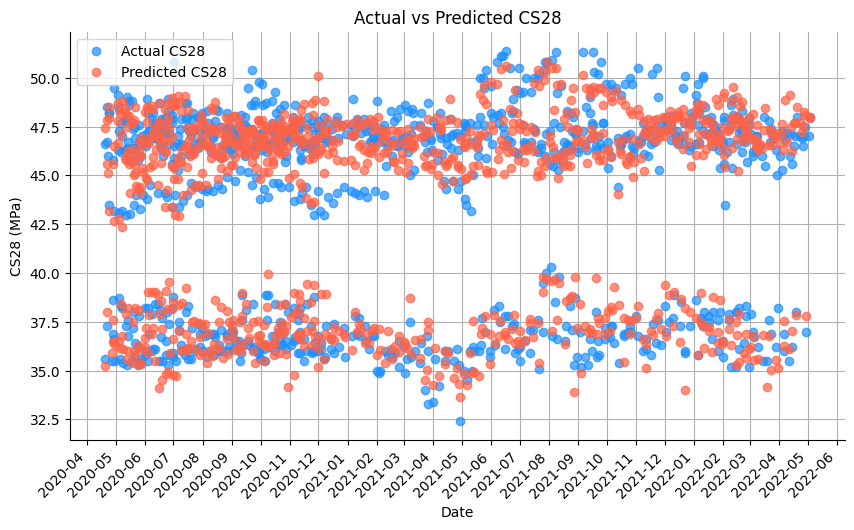

<IPython.core.display.Javascript object>

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


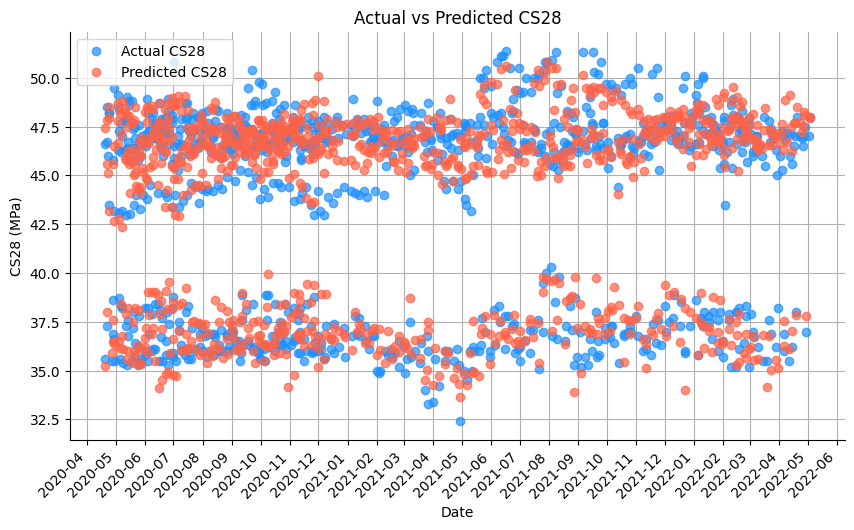

<IPython.core.display.Javascript object>

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [25]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_importances = df_coefs

<IPython.core.display.Javascript object>

In [26]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,...,Dolomite,Quartz,Blaine,Initial setting time,Final setting time,Density,CS3,CS7,#200,#325
Coefficients - 0,0.271794,-0.262128,-0.051140,0.281606,-0.548221,-0.028835,-0.015655,0.248975,0.031293,-0.096085,...,-0.003545,0.203297,-0.169093,0.142350,-0.329754,-0.227680,2.210517,2.170970,-0.544187,0.033088
Coefficients - 1,0.074708,-0.244854,-0.157427,0.211171,-0.185105,-0.070760,0.008904,0.215220,-0.026364,-0.131600,...,-0.103596,-0.043235,-0.068819,0.330611,-0.356824,-0.009133,2.117604,2.090199,-0.145524,-0.433446
Coefficients - 2,0.097694,-0.268540,-0.133441,0.379246,-0.331436,-0.044347,-0.162880,0.168615,0.085770,-0.089915,...,-0.069281,0.077611,-0.163629,0.084663,-0.110095,0.127121,1.672404,2.538323,0.099936,-0.647382
Coefficients - 3,0.022023,-0.219800,-0.096690,0.178771,-0.151319,-0.051923,-0.066632,0.166612,0.005310,0.003800,...,0.024907,0.029704,-0.119031,-0.032563,0.000028,0.143507,1.520243,2.741146,0.166527,-0.717019
Coefficients - 4,0.029436,-0.202929,-0.079122,0.220397,-0.273888,0.006635,-0.021955,0.207062,-0.010791,0.037583,...,0.040334,0.155470,-0.098269,-0.090466,0.011428,0.049414,1.453129,2.881546,0.166453,-0.763700


<IPython.core.display.Javascript object>

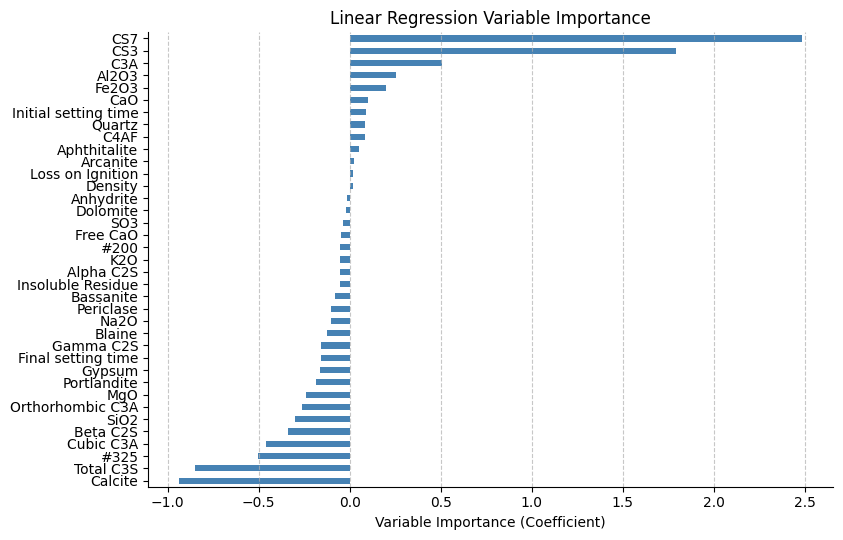

<IPython.core.display.Javascript object>

In [27]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Linear Regression Variable Importance")
plt.xlabel("Variable Importance (Coefficient)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

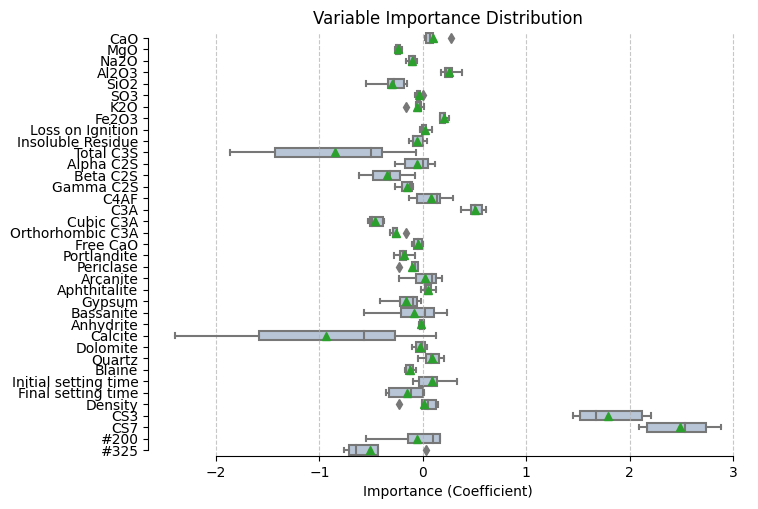

<IPython.core.display.Javascript object>

In [28]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Coefficient)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


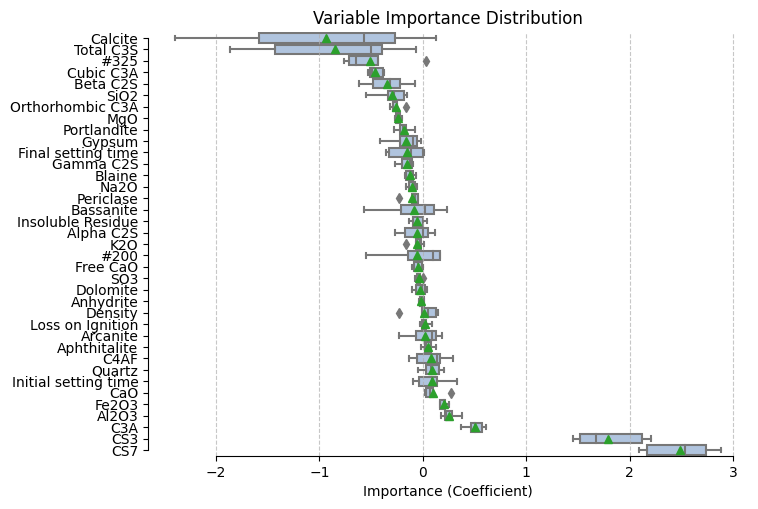

<IPython.core.display.Javascript object>

In [29]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
# df_importances_sorted = df_importances_sorted.rename(
#    columns={"Loss on Ignition": "LOI"}
# )

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Coefficient)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_cs_tiss_linear_regression_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [30]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [31]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

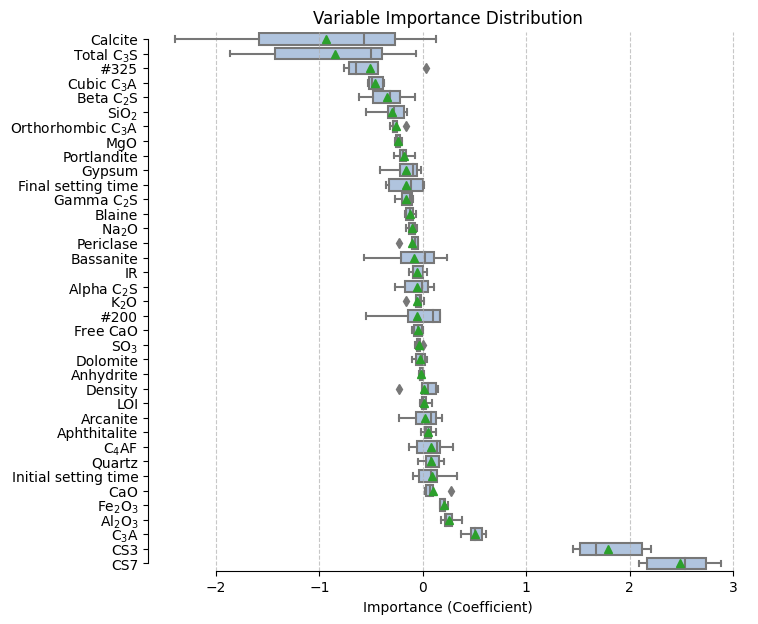

<IPython.core.display.Javascript object>

In [32]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Coefficient)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_cs_tiss_linear_regression_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

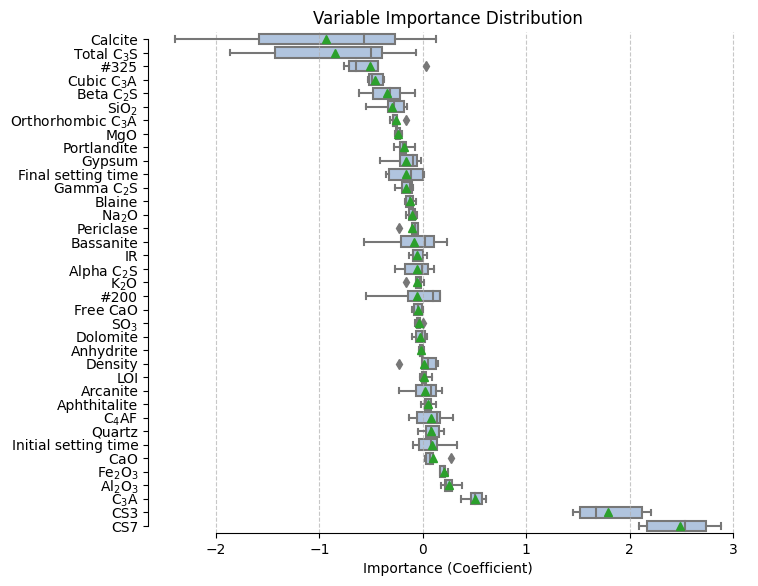

<IPython.core.display.Javascript object>

In [33]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 6.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Coefficient)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [34]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,...,Dolomite,Quartz,Blaine,Initial setting time,Final setting time,Density,CS3,CS7,#200,#325
Coefficients - 0,0.271794,-0.262128,-0.051140,0.281606,-0.548221,-0.028835,-0.015655,0.248975,0.031293,-0.096085,...,-0.003545,0.203297,-0.169093,0.142350,-0.329754,-0.227680,2.210517,2.170970,-0.544187,0.033088
Coefficients - 1,0.074708,-0.244854,-0.157427,0.211171,-0.185105,-0.070760,0.008904,0.215220,-0.026364,-0.131600,...,-0.103596,-0.043235,-0.068819,0.330611,-0.356824,-0.009133,2.117604,2.090199,-0.145524,-0.433446
Coefficients - 2,0.097694,-0.268540,-0.133441,0.379246,-0.331436,-0.044347,-0.162880,0.168615,0.085770,-0.089915,...,-0.069281,0.077611,-0.163629,0.084663,-0.110095,0.127121,1.672404,2.538323,0.099936,-0.647382
Coefficients - 3,0.022023,-0.219800,-0.096690,0.178771,-0.151319,-0.051923,-0.066632,0.166612,0.005310,0.003800,...,0.024907,0.029704,-0.119031,-0.032563,0.000028,0.143507,1.520243,2.741146,0.166527,-0.717019
Coefficients - 4,0.029436,-0.202929,-0.079122,0.220397,-0.273888,0.006635,-0.021955,0.207062,-0.010791,0.037583,...,0.040334,0.155470,-0.098269,-0.090466,0.011428,0.049414,1.453129,2.881546,0.166453,-0.763700


<IPython.core.display.Javascript object>

In [35]:
df_importances.describe().T.sort_values(by=["mean"])

,count,mean,std,min,25%,50%,75%,max
Calcite,5.0,-0.936646,1.032041,-2.391681,-1.585756,-0.566493,-0.271620,0.132320
Total C3S,5.0,-0.851610,0.759872,-1.867755,-1.425657,-0.503311,-0.396622,-0.064707
#325,5.0,-0.505692,0.326652,-0.763700,-0.717019,-0.647382,-0.433446,0.033088
Cubic C3A,5.0,-0.458412,0.072883,-0.530157,-0.514622,-0.486360,-0.382296,-0.378623
Beta C2S,5.0,-0.341114,0.210212,-0.611844,-0.479377,-0.317308,-0.217772,-0.079266
SiO2,5.0,-0.297994,0.156979,-0.548221,-0.331436,-0.273888,-0.185105,-0.151319
Orthorhombic C3A,5.0,-0.260436,0.060630,-0.318368,-0.289658,-0.286951,-0.244409,-0.162793
MgO,5.0,-0.239650,0.027881,-0.268540,-0.262128,-0.244854,-0.219800,-0.202929
Portlandite,5.0,-0.184168,0.072443,-0.273379,-0.221110,-0.187893,-0.159358,-0.079099
Gypsum,5.0,-0.161772,0.161419,-0.415283,-0.223170,-0.098580,-0.051934,-0.019894


<IPython.core.display.Javascript object>

In [36]:
df_importances.mean(axis=0)

CaO                     0.099131
MgO                    -0.239650
Na2O                   -0.103564
Al2O3                   0.254238
SiO2                   -0.297994
SO3                    -0.037846
K2O                    -0.051644
Fe2O3                   0.201297
Loss on Ignition        0.017044
Insoluble Residue      -0.055243
Total C3S              -0.851610
Alpha C2S              -0.054516
Beta C2S               -0.341114
Gamma C2S              -0.157029
C4AF                    0.081178
C3A                     0.506454
Cubic C3A              -0.458412
Orthorhombic C3A       -0.260436
Free CaO               -0.045753
Portlandite            -0.184168
Periclase              -0.100692
Arcanite                0.021545
Aphthitalite            0.048719
Gypsum                 -0.161772
Bassanite              -0.082944
Anhydrite              -0.014330
Calcite                -0.936646
Dolomite               -0.022236
Quartz                  0.084569
Blaine                 -0.123768
Initial se

<IPython.core.display.Javascript object>

In [37]:
df_importances.std(axis=0)

CaO                     0.101506
MgO                     0.027881
Na2O                    0.042388
Al2O3                   0.079169
SiO2                    0.156979
SO3                     0.029084
K2O                     0.067899
Fe2O3                   0.034538
Loss on Ignition        0.043940
Insoluble Residue       0.072117
Total C3S               0.759872
Alpha C2S               0.159190
Beta C2S                0.210212
Gamma C2S               0.074055
C4AF                    0.172427
C3A                     0.095341
Cubic C3A               0.072883
Orthorhombic C3A        0.060630
Free CaO                0.048100
Portlandite             0.072443
Periclase               0.075085
Arcanite                0.169873
Aphthitalite            0.054064
Gypsum                  0.161419
Bassanite               0.316661
Anhydrite               0.020853
Calcite                 1.032041
Dolomite                0.061886
Quartz                  0.098127
Blaine                  0.042823
Initial se

<IPython.core.display.Javascript object>

In [38]:
df_importances.std(axis=0, ddof=0)

CaO                     0.090790
MgO                     0.024938
Na2O                    0.037913
Al2O3                   0.070811
SiO2                    0.140407
SO3                     0.026013
K2O                     0.060730
Fe2O3                   0.030891
Loss on Ignition        0.039301
Insoluble Residue       0.064503
Total C3S               0.679650
Alpha C2S               0.142384
Beta C2S                0.188019
Gamma C2S               0.066237
C4AF                    0.154223
C3A                     0.085276
Cubic C3A               0.065189
Orthorhombic C3A        0.054229
Free CaO                0.043022
Portlandite             0.064795
Periclase               0.067158
Arcanite                0.151939
Aphthitalite            0.048356
Gypsum                  0.144378
Bassanite               0.283230
Anhydrite               0.018652
Calcite                 0.923085
Dolomite                0.055352
Quartz                  0.087768
Blaine                  0.038302
Initial se

<IPython.core.display.Javascript object>

In [39]:
df_copy.nunique()

Date                     651
CaO                     1215
MgO                     1216
Na2O                    1107
Al2O3                   1208
SiO2                    1213
SO3                     1213
K2O                     1178
Fe2O3                   1207
Loss on Ignition         579
Insoluble Residue        410
Total C3S                882
Alpha C2S                335
Beta C2S                 626
Gamma C2S                178
C4AF                     451
C3A                      310
Cubic C3A                278
Orthorhombic C3A         204
Free CaO                 167
Portlandite              292
Periclase                247
Arcanite                 267
Aphthitalite             104
Gypsum                   383
Bassanite                472
Anhydrite                 48
Calcite                  810
Dolomite                 293
Quartz                   256
Blaine                   349
Initial setting time      17
Final setting time        17
Density                   10
CS3           

<IPython.core.display.Javascript object>

In [40]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'transformer': StandardScaler(),
 'estimator': LinearRegression()}

<IPython.core.display.Javascript object>

In [41]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [42]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    scaler = pipeline.named_steps["transformer"]
    # Compute MDI importance
    # mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        scaler.transform(imputer.transform(x.iloc[test_idx])),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

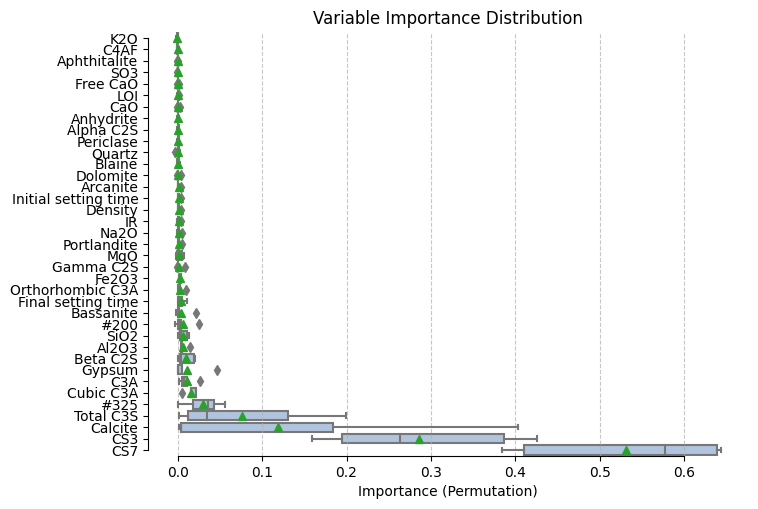

<IPython.core.display.Javascript object>

In [43]:
# Convert lists to DataFrames
# mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_cs_tiss_linear_regression_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

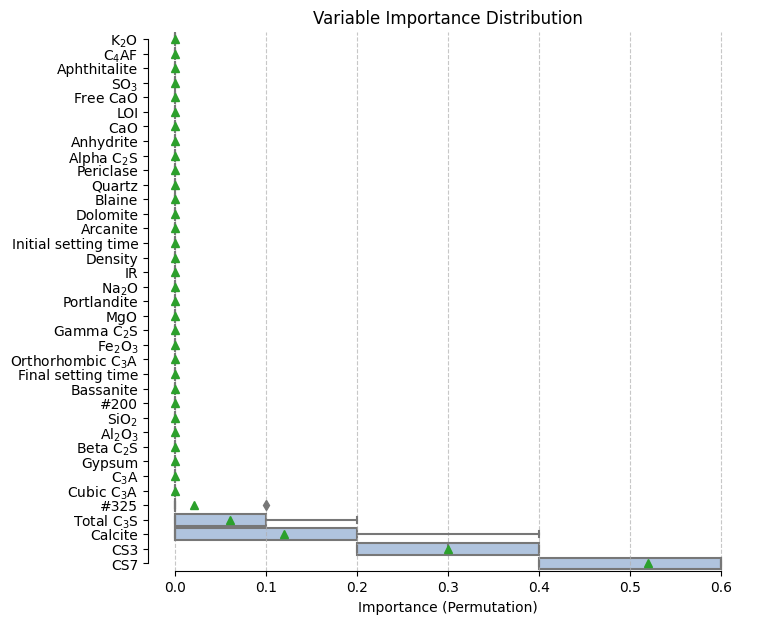

<IPython.core.display.Javascript object>

In [44]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=perm_importances_df_plot.round(1),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_cs_tiss_linear_regression_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

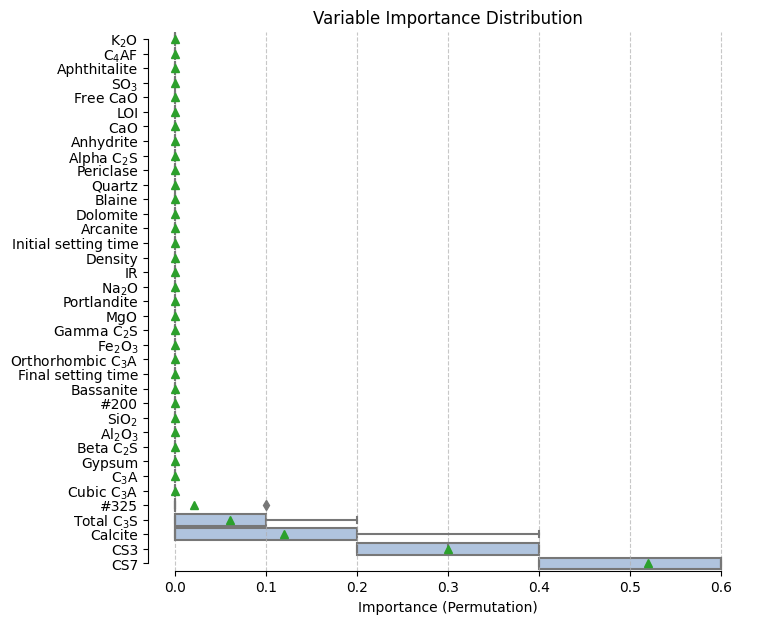

<IPython.core.display.Javascript object>

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI"
    }
)

plt.figure(figsize=(10, 7))

# Create boxplot
sns.boxplot(
    data=perm_importances_df_plot.round(1),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)

# Set x-axis label and title
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")

# Add gridlines for x-axis
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Format x-axis to show 1 decimal place
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust the layout to prevent label cut-off
plt.subplots_adjust(left=0.3)

# Save the plot
plt.savefig(
    "inn_cm_p_cs_tiss_linear_regression_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

# Reset all rcParams to their default values
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)


In [46]:
perm_importances_df.describe().round(4).T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
K2O,5.0,-0.0009,0.0010,-0.0024,-0.0013,-0.0004,-0.0003,-0.0002
C4AF,5.0,-0.0002,0.0009,-0.0014,-0.0007,-0.0004,0.0004,0.0010
Aphthitalite,5.0,-0.0002,0.0007,-0.0015,0.0001,0.0001,0.0001,0.0003
SO3,5.0,-0.0002,0.0005,-0.0011,-0.0002,0.0000,0.0002,0.0002
Free CaO,5.0,0.0001,0.0007,-0.0009,-0.0001,-0.0000,0.0002,0.0011
LOI,5.0,0.0002,0.0009,-0.0007,-0.0002,0.0000,0.0002,0.0018
CaO,5.0,0.0003,0.0014,-0.0014,-0.0000,-0.0000,0.0001,0.0026
Anhydrite,5.0,0.0003,0.0008,-0.0007,0.0001,0.0001,0.0007,0.0014
Alpha C2S,5.0,0.0004,0.0012,-0.0012,0.0000,0.0002,0.0014,0.0017
Periclase,5.0,0.0005,0.0008,-0.0008,0.0002,0.0006,0.0010,0.0013


<IPython.core.display.Javascript object>

In [47]:
perm_importances_df

,K2O,C4AF,Aphthitalite,SO3,Free CaO,LOI,CaO,Anhydrite,Alpha C2S,Periclase,...,Al2O3,Beta C2S,Gypsum,C3A,Cubic C3A,#325,Total C3S,Calcite,CS3,CS7
0,-0.000172,-0.000682,0.000292,-0.000158,0.001139,-0.000720,0.002591,0.001400,1.362063e-03,-0.000826,...,0.005497,0.019974,0.046454,0.025766,0.021554,-0.000355,0.199838,0.402689,0.425489,0.409911
1,-0.000298,-0.000404,0.000146,0.000207,0.000179,0.000185,0.000120,0.000719,1.723940e-03,0.000638,...,0.004411,0.019255,0.005134,0.007707,0.015374,0.017523,0.130364,0.183544,0.386513,0.384458
2,-0.002449,-0.001432,0.000096,0.000209,-0.000851,0.001751,-0.001363,-0.000671,7.152528e-07,0.000152,...,0.013882,0.003018,-0.000271,0.011463,0.021602,0.035719,0.034259,0.003896,0.262823,0.577229
3,-0.001250,0.000995,0.000062,-0.001095,-0.000035,0.000032,-0.000033,0.000062,1.774907e-04,0.001266,...,0.003745,0.003912,0.000485,0.001642,0.015662,0.056039,0.012283,0.001254,0.194437,0.639452
4,-0.000386,0.000416,-0.001496,0.000013,-0.000108,-0.000195,-0.000036,0.000095,-1.202740e-03,0.001046,...,0.004049,0.000344,-0.000019,0.005296,0.004929,0.043198,0.000969,0.003544,0.159262,0.643640


<IPython.core.display.Javascript object>

In [48]:
perm_importances_df.mean(axis=0)

K2O                    -0.000911
C4AF                   -0.000221
Aphthitalite           -0.000180
SO3                    -0.000165
Free CaO                0.000065
LOI                     0.000211
CaO                     0.000256
Anhydrite               0.000321
Alpha C2S               0.000412
Periclase               0.000455
Quartz                  0.000470
Blaine                  0.000509
Dolomite                0.000536
Arcanite                0.000857
Initial setting time    0.000926
Density                 0.000929
IR                      0.000983
Na2O                    0.001193
Portlandite             0.001499
MgO                     0.001592
Gamma C2S               0.001611
Fe2O3                   0.002657
Orthorhombic C3A        0.003026
Final setting time      0.003502
Bassanite               0.004214
#200                    0.005664
SiO2                    0.006287
Al2O3                   0.006317
Beta C2S                0.009301
Gypsum                  0.010357
C3A       

<IPython.core.display.Javascript object>

In [49]:
perm_importances_df.std(axis=0, ddof=0)

K2O                     0.000858
C4AF                    0.000848
Aphthitalite            0.000663
SO3                     0.000485
Free CaO                0.000639
LOI                     0.000829
CaO                     0.001285
Anhydrite               0.000696
Alpha C2S               0.001045
Periclase               0.000745
Quartz                  0.001866
Blaine                  0.001364
Dolomite                0.001480
Arcanite                0.001588
Initial setting time    0.001334
Density                 0.001334
IR                      0.001858
Na2O                    0.002058
Portlandite             0.001901
MgO                     0.003651
Gamma C2S               0.003576
Fe2O3                   0.000977
Orthorhombic C3A        0.003159
Final setting time      0.004231
Bassanite               0.008508
#200                    0.010190
SiO2                    0.005006
Al2O3                   0.003828
Beta C2S                0.008506
Gypsum                  0.018157
C3A       

<IPython.core.display.Javascript object>

In [50]:
# np.std(y)
len(y)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)
df["CS28"].describe().T

count    1226.000000
mean       43.514405
std         5.047022
min        32.400002
25%        37.425001
50%        46.299999
75%        47.299999
max        51.400002
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>